# Preprocessing and Modeling

## Contents
-  [Data Import and Cleaning](#Data-Import-and-Cleaning)
-  [Sandy Hurricane](#Sandy-Hurricane)
-  [Oklahoma Tornado](#Oklahoma-Tornado)
-  [Alberta Floods and Queensland Flood](#Alberta-Floods-and-Queensland-Flood)
-  [All Disasters](#All-Disasters)
-  [Pickle Models for Future Predictions](#Pickle-Models-for-Future-Predictions)

In [1]:
import pickle, warnings

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
sns.set_palette(palette='colorblind')
np.random.seed(44)
%matplotlib inline

np.

## Data Import and Cleaning

In [2]:
final_df = pd.read_csv('./data/final_df', na_filter=False)

In [3]:
final_df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
final_df.head()

,id,text,label_on-topic,disaster_type,processed,tokenized,lemmatized
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,False,hurricane,i've got enough candles to supply a mexican fa...,"['i', 've', 'got', 'enough', 'candles', 'to', ...",i ve got enough candle to supply a mexican family
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,True,hurricane,sandy be soooo mad that she be shattering our ...,"['sandy', 'be', 'soooo', 'mad', 'that', 'she',...",sandy be soooo mad that she be shattering our ...
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,False,hurricane,ibexgirl thankfully hurricane waugh played it ...,"['ibexgirl', 'thankfully', 'hurricane', 'waugh...",ibexgirl thankfully hurricane waugh played it ...
3,'263422851133079552',@taos you never got that magnificent case of B...,False,hurricane,taos you never got that magnificent case of bu...,"['taos', 'you', 'never', 'got', 'that', 'magni...",tao you never got that magnificent case of bur...
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",False,hurricane,"i'm at mad river bar &amp; grille (new york, ny)","['i', 'm', 'at', 'mad', 'river', 'bar', 'amp',...",i m at mad river bar amp grille new york ny


We'll check our target feature `label_on-topic` to make sure our data was imported correctly.

In [5]:
final_df['label_on-topic'].value_counts()

True                                                         21568
False                                                        18495
                                                                 2
&amp; i anit offering that shit to oomf anymore . toodone        1
Name: label_on-topic, dtype: int64

We expect to only see either 1 for `on-topic` or 0 for `off-topic`. We will drop all rows that don't equate to that.

In [6]:
final_df = final_df[(final_df['label_on-topic'] != '') & 
                    (final_df['label_on-topic'] != '&amp; i anit offering that shit to oomf anymore . toodone')]

We will filter our dataframe and arbitrarily choose disaster types to model on. We expect to see the same trends for all disaster types.

In [7]:
final_df.head()

,id,text,label_on-topic,disaster_type,processed,tokenized,lemmatized
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,False,hurricane,i've got enough candles to supply a mexican fa...,"['i', 've', 'got', 'enough', 'candles', 'to', ...",i ve got enough candle to supply a mexican family
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,True,hurricane,sandy be soooo mad that she be shattering our ...,"['sandy', 'be', 'soooo', 'mad', 'that', 'she',...",sandy be soooo mad that she be shattering our ...
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,False,hurricane,ibexgirl thankfully hurricane waugh played it ...,"['ibexgirl', 'thankfully', 'hurricane', 'waugh...",ibexgirl thankfully hurricane waugh played it ...
3,'263422851133079552',@taos you never got that magnificent case of B...,False,hurricane,taos you never got that magnificent case of bu...,"['taos', 'you', 'never', 'got', 'that', 'magni...",tao you never got that magnificent case of bur...
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",False,hurricane,"i'm at mad river bar &amp; grille (new york, ny)","['i', 'm', 'at', 'mad', 'river', 'bar', 'amp',...",i m at mad river bar amp grille new york ny


## Sandy Hurricane

### Model Prep

In [8]:
X = final_df.loc[final_df['disaster_type'] == 'hurricane', ['lemmatized']]
y = final_df.loc[final_df['disaster_type'] == 'hurricane', ['label_on-topic']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    random_state=44)

#### TF-IDF

We want to use TF-IDF to determine which words are most discriminating between tweets. Words that occur frequently are penalized and rare words are given more influence in our model. 

We instantiate TfidfVectorizer() and set:
-  `ngram_range = (1, 2)`: Set an upper and lower bound of 1 and 2. Word sequence will contain at least 1 and up to 2 words.
-  `stop_words='english'`: Filter out commonly used words in English
-  `min_df = 25`: Ignore terms that occur in less than 25 documents of the corpus
-  `max_df = 1.0`: There is no maximum threshold since terms cannot have a document frequency greater than `100%`. 

We then create a dataframe that contains each word and its frequency. This is done for both `X_train` and `X_test`.

##### X_train

In [10]:
tfidf_sh = TfidfVectorizer(ngram_range=(1, 2),
                           stop_words='english',
                           min_df=25, 
                           max_df=1.0)
X_train_tfidf = tfidf_sh.fit_transform(X_train['lemmatized'])
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_sh.get_feature_names())

##### Replicate for X_test

In [11]:
X_test_tfidf = tfidf_sh.transform(X_test['lemmatized'])
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_sh.get_feature_names())

In [12]:
X_test_tfidf_df.shape

(2502, 421)

### Modeling

#### Baseline Model

In [13]:
y['label_on-topic'].value_counts(normalize=True)

True     0.613309
False    0.386691
Name: label_on-topic, dtype: float64

Since `on-topic` is our majority class, an accuracy score of 61.33% is our baseline model. If we classify all tweets as being `on-topic`, we will be predicting correctly 61.33% of the time.

#### Random Forest

We will use Random Forest in order to measure feature importance and determine which terms provide the most information gained. 

We instantiate Random Forest Classifier and perform Grid Search to find the most optimal hyperparameters:
-  **n_estimators**: Number of trees our model builds before taking an average of the predictions. 
-  **min_samples_split**: Minimum number of samples required for a node to split
-  **max_depth**: Maximum number of levels in each tree. We include the default value of `None` in addition to our other values.

In [14]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [30, 35, 45],
    'min_samples_split': [2, 3, 5, 7, 10],
    'max_depth': [None, 5, 7, 10]
    
}
gs_rf_sh = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf_sh.fit(X_train_tfidf_df, y_train['label_on-topic'])
print('Score on Training Set:', gs_rf_sh.score(X_train_tfidf_df, y_train['label_on-topic']))
print('Score on Testing Set:', gs_rf_sh.score(X_test_tfidf_df, y_test['label_on-topic']))
gs_rf_sh.best_params_

Score on Training Set: 0.9661604050093259
Score on Testing Set: 0.9224620303756994


{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 35}

### Confusion Matrix

To show the type of error our model is prone to, we will create a confusion matrix showing the count of true positives, true negatives, false positives (type I error) and false negatives (type II error).

In [15]:
cm = confusion_matrix(y_test, gs_rf_sh.predict(X_test_tfidf_df))

In [16]:
cm_df = pd.DataFrame(cm, columns = ('predict_0','predict_1') , index = ('actual_0', 'actual_1'))
cm_df

,predict_0,predict_1
actual_0,860,108
actual_1,86,1448


-  For `y_train`, we will correctly predict the class in which a tweet belongs in `96.94%` of the time.
-  For `y_test`, we will correctly predict the class in which a tweet belongs in `92.49%` of the time.

##### Takeaways

-  The model is suffering from high variance, with our training score being rougly `4.45%` higher than our test score. 
-  The accuracy scores are greater than our baseline model of `61.33%`.

##### Important Features

In [17]:
feat_importance = pd.DataFrame(gs_rf_sh.best_estimator_.feature_importances_, X_train_tfidf_df.columns, columns=['importance'])

In [18]:
top_feat = feat_importance.sort_values('importance', ascending=False).head(20)

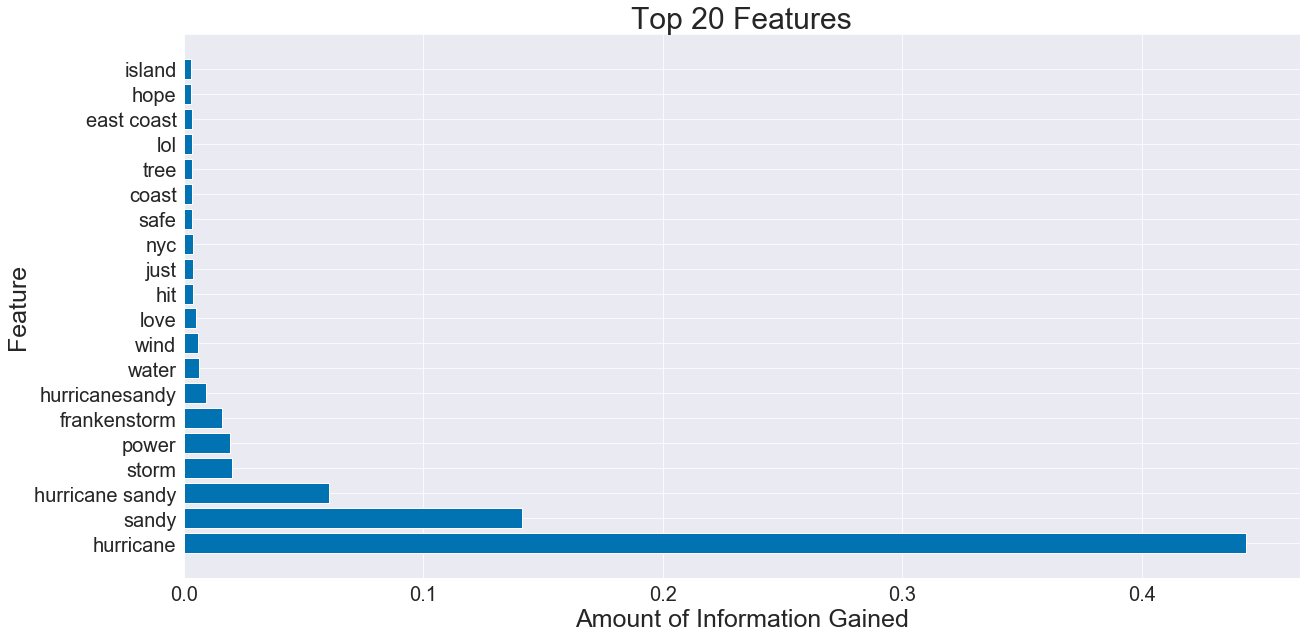

In [19]:
plt.figure(figsize=(20,10))
plt.barh(top_feat.index, top_feat['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of Information Gained', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  Terms with the most information gained are either referring to the disaster type (`hurricane`) or the name itself.
-  Words like `safe`, `love`, and`hope` are most likely from well-wishers not affected by the disaster.

#### Logistic Regression

We will use logistic regression to measure feature importance and determine the words contained in tweets that give them high odds of being classified as `on-topic`. Grid-search was applied on logistic regression to calculate the best hyperparameters for our model.
- **'C'**: Inverse of regularization strength where smaller values specify stronger regularization
- **'penalty'**: Specifies the regularization norm

In [20]:
lr = LogisticRegression()
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'penalty' : ['l1','l2']   
}
gs_lr_sh = GridSearchCV(lr, param_grid = lr_params, scoring = 'roc_auc', cv = 3)
gs_lr_sh.fit(X_train_tfidf_df, y_train['label_on-topic'])
print('Score on Training Set:', gs_lr_sh.score(X_train_tfidf_df, y_train['label_on-topic']))
print('Score on Testing Set:', gs_lr_sh.score(X_test_tfidf_df, y_test['label_on-topic']))
gs_lr_sh.best_params_

Score on Training Set: 0.968593778160722
Score on Testing Set: 0.9606262862715096


{'C': 1, 'penalty': 'l2'}

### Confusion Matrix

In [21]:
cm = confusion_matrix(y_test, gs_lr_sh.predict(X_test_tfidf_df))

In [22]:
cm_df = pd.DataFrame(cm, columns = ('predict_0','predict_1') , index = ('actual_0', 'actual_1'))
cm_df

,predict_0,predict_1
actual_0,882,86
actual_1,109,1425


-  For `y_train`, we will correctly predict the class in which a tweet belongs in `96.86%` of the time.
-  For `y_test`, we will correctly predict the class in which a tweet belongs in `96.06%` of the time.

##### Takeaways
- The model is still slightly overfitting to the train data because the variance explained from train data is 0.8% higher than the variance explained in the test data.

In [23]:
lr_sh_odds = pd.DataFrame(gs_lr_sh.best_estimator_.coef_, columns = X_train_tfidf_df.columns).T
lr_sh_odds.columns = ['weights']
lr_sh_odds['odds'] = np.exp(lr_sh_odds['weights'])
lr_sh_odds.sort_values(by='odds', ascending=False).head(20)

,weights,odds
hurricane,15.545379,5.639912e+06
sandy,8.370842,4.319269e+03
storm,4.600614,9.954538e+01
frankenstorm,4.521823,9.200315e+01
hurricanesandy,4.204209,6.696764e+01
power,3.645939,3.831872e+01
hurricane sandy,2.705418,1.496057e+01
water,2.627362,1.383722e+01
flood,2.391798,1.093314e+01
wind,2.366369,1.065863e+01


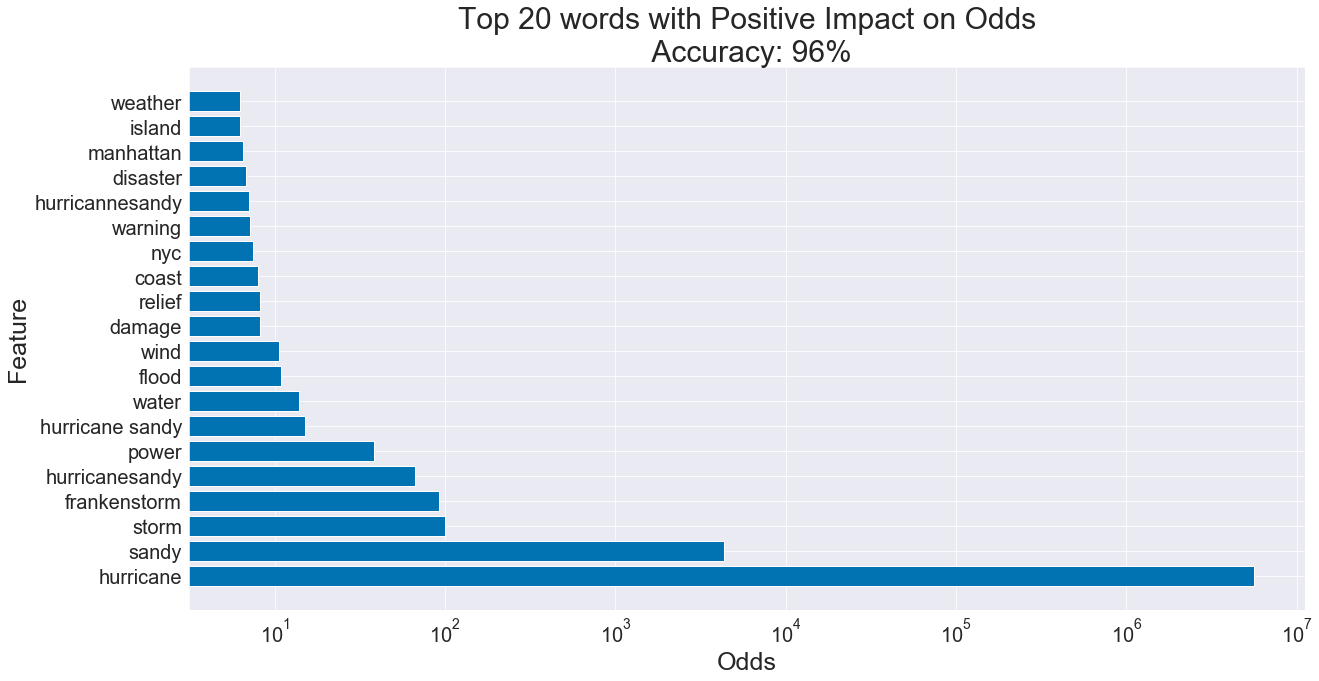

In [24]:
plt.figure(figsize=(20,10))
plt.barh(lr_sh_odds.sort_values(by='odds', ascending=False).head(20).index, 
         lr_sh_odds.sort_values(by='odds', ascending=False).head(20)['odds'],
         log=True)
plt.title(f'Top 20 words with Positive Impact on Odds\n Accuracy: 96%', fontsize=30)
plt.xlabel('Odds', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## Oklahoma Tornado

### Model Prep

In [25]:
X = final_df.loc[final_df['disaster_type'] == 'tornado', ['lemmatized']]
y = final_df.loc[final_df['disaster_type'] == 'tornado', ['label_on-topic']]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    random_state=44)

#### TF-IDF

We instantiate TfidfVectorizer() and set the same parameters as before.

##### X_train

In [27]:
tfidf_ot = TfidfVectorizer(ngram_range=(1, 2),
                           stop_words='english',
                           min_df=25, 
                           max_df=1.0)
X_train_tfidf = tfidf_ot.fit_transform(X_train['lemmatized'])
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_ot.get_feature_names())

##### Replicate for X_test

In [28]:
X_test_tfidf = tfidf_ot.transform(X_test['lemmatized'])
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_ot.get_feature_names())

In [29]:
X_test_tfidf_df.shape

(2498, 460)

### Modeling

#### Baseline Model

In [30]:
y['label_on-topic'].value_counts(normalize=True)

False    0.516865
True     0.483135
Name: label_on-topic, dtype: float64

`on-topic` is our majority class again, with a similar imbalance as Alberta Floods and Queensland Flood. If we classify all tweets as being `on-topic`, we will be predicting correctly 53.84% of the time.

#### Random Forest

In [31]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [30, 35, 45],
    'min_samples_split': [2, 3, 5, 7, 10],
    'max_depth': [None, 5, 7, 10]
    
}
gs_rf_ot = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf_ot.fit(X_train_tfidf_df, y_train['label_on-topic'])
print('Score on Training Set:', gs_rf_ot.score(X_train_tfidf_df, y_train['label_on-topic']))
print('Score on Testing Set:', gs_rf_ot.score(X_test_tfidf_df, y_test['label_on-topic']))
gs_rf_ot.best_params_

Score on Training Set: 0.977445615908181
Score on Testing Set: 0.9359487590072058


{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 45}

-  For `y_train`, we will correctly predict the class in which a tweet belongs in `97.74%` of the time.
-  For `y_test`, we will correctly predict the class in which a tweet belongs in `93.59%` of the time.

### Confusion Matrix

In [32]:
cm = confusion_matrix(y_test, gs_rf_ot.predict(X_test_tfidf_df))

In [33]:
cm_df = pd.DataFrame(cm, columns = ('predict_0','predict_1') , index = ('actual_0', 'actual_1'))
cm_df

,predict_0,predict_1
actual_0,1184,107
actual_1,53,1154


##### Takeaways

-  The model is suffering from high variance, with our training score being rougly `4.15%` higher than our test score. 
-  The accuracy scores are greater than our baseline model of `61.33%`.

##### Important Features

We generated using gridsearch the most importance features that provide the most amount of information gained and plotted the top 20 words.

In [34]:
feat_importance = pd.DataFrame(gs_rf_ot.best_estimator_.feature_importances_, X_train_tfidf_df.columns, columns=['importance'])

In [35]:
top_feat = feat_importance.sort_values('importance', ascending=False).head(20)

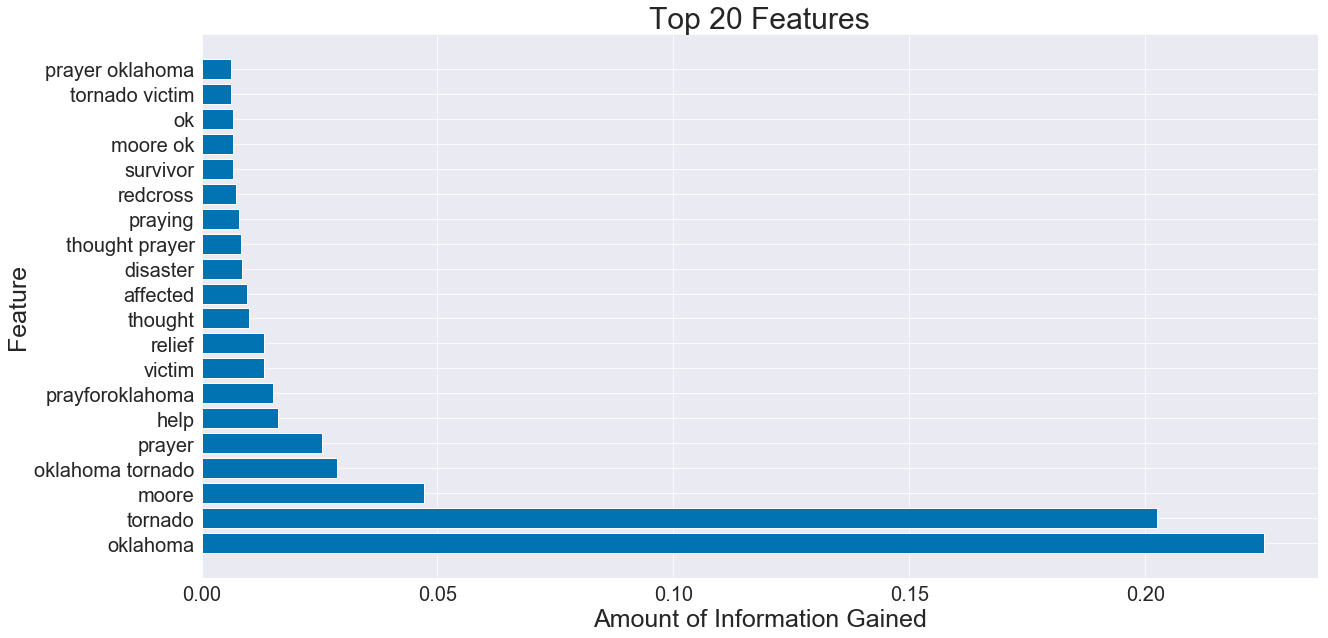

In [36]:
plt.figure(figsize=(20,10))
plt.barh(top_feat.index, top_feat['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of Information Gained', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  Terms with the most information gained are either referring to the disaster type (`tornado`) or the name itself.
-  Words like `tornado victim`, `prayer oklahoma`, and `ok` are most likely from well-wishers not affected by the disaster.

#### Logistic Regression

We will use logistic regression to measure feature importance and determine the words contained in tweets that give them high odds of being classified as `on-topic`. Grid-search was applied on logistic regression to calculate the best hyperparameters for our model.
- <b>'C': Inverse of regularization strength where smaller values specify stronger regularization
- <b>'penalty': Specifies the regularization norm

In [37]:
lr = LogisticRegression()
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'penalty' : ['l1','l2']   
}
gs_lr_ot = GridSearchCV(lr, param_grid = lr_params, scoring = 'roc_auc', cv = 3)
gs_lr_ot.fit(X_train_tfidf_df, y_train['label_on-topic'])
print('Score on Training Set:', gs_lr_ot.score(X_train_tfidf_df, y_train['label_on-topic']))
print('Score on Testing Set:', gs_lr_ot.score(X_test_tfidf_df, y_test['label_on-topic']))
gs_lr_ot.best_params_

Score on Training Set: 0.9827201849323763
Score on Testing Set: 0.9728337216995875


{'C': 10, 'penalty': 'l2'}

-  For `y_train`, we will correctly predict the class in which a tweet belongs in `98.27%` of the time.
-  For `y_test`, we will correctly predict the class in which a tweet belongs in `97.28%` of the time.

### Confusion Matrix

In [38]:
cm = confusion_matrix(y_test, gs_lr_ot.predict(X_test_tfidf_df))

In [39]:
cm_df = pd.DataFrame(cm, columns = ('predict_0','predict_1') , index = ('actual_0', 'actual_1'))
cm_df

,predict_0,predict_1
actual_0,1211,80
actual_1,102,1105


##### Takeaways
- The model is still slightly overfitting to the train data because the variance explained from train data is 1% higher than the variance explained in the test data.

##### Odds

We made a table of the top 20 words with positive impact on odds meaning tweets with these words have the highest odds of being classified as `on-topic`. The tweets containing the word `tornado` are 149081 times as likely to be classified as `on-topic`.

In [40]:
lr_ot_odds = pd.DataFrame(gs_lr_ot.best_estimator_.coef_, columns = X_train_tfidf_df.columns).T
lr_ot_odds.columns = ['weights']
lr_ot_odds['odds'] = np.exp(lr_ot_odds['weights'])
lr_ot_odds.sort_values(by='odds', ascending=False).head(20)

,weights,odds
tornado,11.912231,149078.846090
prayforoklahoma,9.119605,9132.597469
prayer,8.688379,5933.553336
oklahoma,8.001139,2984.355241
devastation,7.723858,2261.668287
donation,6.444024,628.932453
victim,6.374967,586.965793
redcross,6.161849,474.304343
donating,5.721448,305.346807
disaster,5.568342,261.999434


We created a horizontal bar chart of the top 20 words of our logistic regression model that have the highest odds of classifying a tweet as `on-topic`.

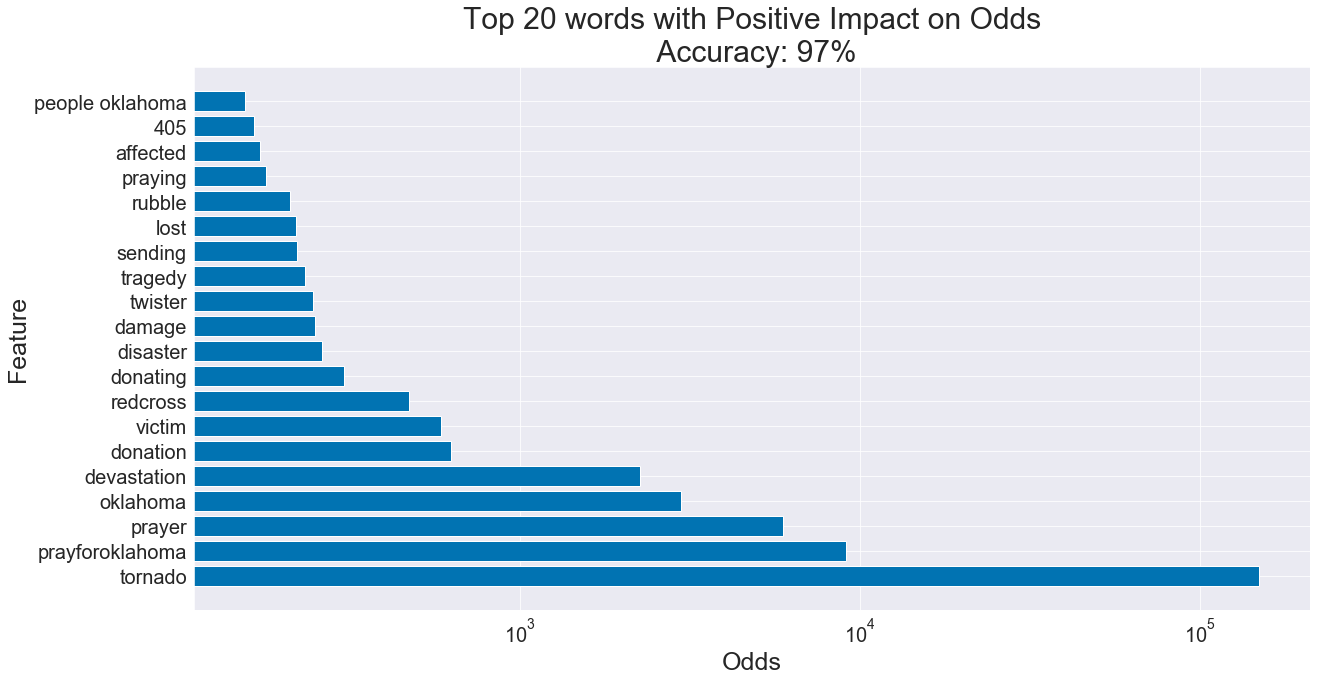

In [41]:
plt.figure(figsize=(20,10))
plt.barh(lr_ot_odds.sort_values(by='odds', ascending=False).head(20).index, 
         lr_ot_odds.sort_values(by='odds', ascending=False).head(20)['odds'],
         log=True)
plt.title('Top 20 words with Positive Impact on Odds\n Accuracy: 97%', fontsize=30)
plt.xlabel('Odds', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

- words such as tornado and oklahoma are referencing the tornado disaster itself in Oklahoma
- words such as affected and praying are most likely from people not affected by the disasters who are talking about the disasters

## Alberta Floods and Queensland Flood

We repeat the same process for disaster type `flood` (Alberta and Queensland).

### Model Prep

In [42]:
X = final_df.loc[final_df['disaster_type'] == 'flood', ['lemmatized']]
y = final_df.loc[final_df['disaster_type'] == 'flood', ['label_on-topic']]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    random_state=44)

#### TF-IDF

We instantiate TfidfVectorizer() and set the same parameters as before.

##### X_train

In [44]:
tfidf_fl = TfidfVectorizer(ngram_range=(1, 2),
                           stop_words='english',
                           min_df=25, 
                           max_df=1.0)
X_train_tfidf = tfidf_fl.fit_transform(X_train['lemmatized'])
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_fl.get_feature_names())

##### Replicate for X_test

In [45]:
X_test_tfidf = tfidf_fl.transform(X_test['lemmatized'])
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_fl.get_feature_names())

In [46]:
X_test_tfidf_df.shape

(5016, 1060)

### Modeling

#### Baseline Model

In [47]:
y['label_on-topic'].value_counts(normalize=True)

True     0.528459
False    0.471541
Name: label_on-topic, dtype: float64

`on-topic` is our majority class again, but we do not see as great of an imbalance as we did with Sandy Hurricane. If we classify all tweets as being `on-topic`, we will be predicting correctly 52.85% of the time.

#### Random Forest

In [48]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [30, 35, 45],
    'min_samples_split': [2, 3, 5, 7, 10],
    'max_depth': [None, 5, 7, 10]
    
}
gs_rf_fl = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf_fl.fit(X_train_tfidf_df, y_train['label_on-topic'])
print('Score on Training Set:', gs_rf_fl.score(X_train_tfidf_df, y_train['label_on-topic']))
print('Score on Testing Set:', gs_rf_fl.score(X_test_tfidf_df, y_test['label_on-topic']))
gs_rf_fl.best_params_

Score on Training Set: 0.9869750132908027
Score on Testing Set: 0.9599282296650717


{'max_depth': None, 'min_samples_split': 7, 'n_estimators': 45}

-  For `y_train`, we will correctly predict the class in which a tweet belongs in `98.56%` of the time.
-  For `y_test`, we will correctly predict the class in which a tweet belongs in `95.95%` of the time.

### Confusion Matrix

In [49]:
cm = confusion_matrix(y_test, gs_rf_fl.predict(X_test_tfidf_df))

In [50]:
cm_df = pd.DataFrame(cm, columns = ('predict_0','predict_1') , index = ('actual_0', 'actual_1'))
cm_df

,predict_0,predict_1
actual_0,2235,130
actual_1,71,2580


##### Important Features

We generated using gridsearch the most importance features that provide the most amount of information gained and plotted the top 20 words.

In [51]:
feat_importance = pd.DataFrame(gs_rf_fl.best_estimator_.feature_importances_, X_train_tfidf_df.columns, columns=['importance'])

In [52]:
top_feat = feat_importance.sort_values('importance', ascending=False).head(20)

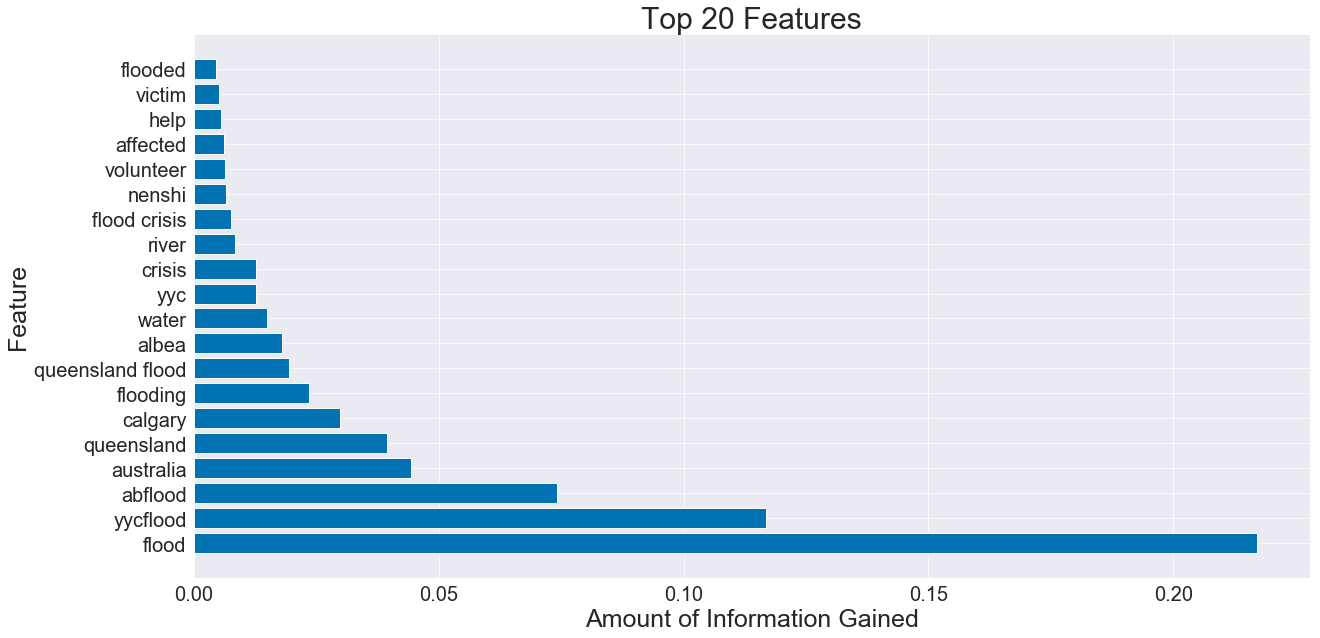

In [53]:
plt.figure(figsize=(20,10))
plt.barh(top_feat.index, top_feat['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of Information Gained', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  Similar to what we saw with Sandy Hurricane, the words with the most information gained are either referring to the disaster type (`flood`) or the name directly.
-  There are several terms that refer to the flood location: `yycflood`, `queensland`, `calgary`, and `albea`.

#### Logistic Regression

We will use logistic regression to measure feature importance and determine the words contained in tweets that give them high odds of being classified as `on-topic`. Grid-search was applied on logistic regression to calculate the best hyperparameters for our model.

In [54]:
lr = LogisticRegression()
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'penalty' : ['l1','l2']   
}
gs_lr_fl = GridSearchCV(lr, param_grid = lr_params, scoring = 'roc_auc', cv = 3)
gs_lr_fl.fit(X_train_tfidf_df, y_train['label_on-topic'])
print('Score on Training Set:', gs_lr_fl.score(X_train_tfidf_df, y_train['label_on-topic']))
print('Score on Testing Set:', gs_lr_fl.score(X_test_tfidf_df, y_test['label_on-topic']))
gs_lr_fl.best_params_

Score on Training Set: 0.9930616676382987
Score on Testing Set: 0.9853711910539962


{'C': 10, 'penalty': 'l2'}

-  For `y_train`, we will correctly predict the class in which a tweet belongs in `98.27%` of the time.
-  For `y_test`, we will correctly predict the class in which a tweet belongs in `97.28%` of the time.

### Confusion Matrix

In [55]:
cm = confusion_matrix(y_test, gs_lr_fl.predict(X_test_tfidf_df))

In [56]:
cm_df = pd.DataFrame(cm, columns = ('predict_0','predict_1') , index = ('actual_0', 'actual_1'))
cm_df

,predict_0,predict_1
actual_0,2256,109
actual_1,100,2551


##### Odds

We made a table of the top 20 words with positive impact on odds meaning tweets with these words have the highest odds of being classified as `on-topic`. The tweets containing the word `tornado` are 149081 times as likely to be classified as `on-topic`.

In [57]:
lr_fl_odds = pd.DataFrame(gs_lr_fl.best_estimator_.coef_, columns = X_train_tfidf_df.columns).T
lr_fl_odds.columns = ['weights']
lr_fl_odds['odds'] = np.exp(lr_fl_odds['weights'])
lr_fl_odds.sort_values(by='odds', ascending=False).head(20)

,weights,odds
flood,30.168910,1.265293e+13
yycflood,18.319683,9.039349e+07
abflood,16.000194,8.887837e+06
flooding,11.683274,1.185718e+05
flooded,10.074546,2.373120e+04
storm,8.158508,3.492970e+03
yycfloods,7.628064,2.055068e+03
abfloods,6.979969,1.074885e+03
queensland flood,6.975785,1.070397e+03
queensland,6.966846,1.060871e+03


We created a horizontal bar chart of the top 20 words of our logistic regression model that have the highest odds of classifying a tweet as `on-topic`.

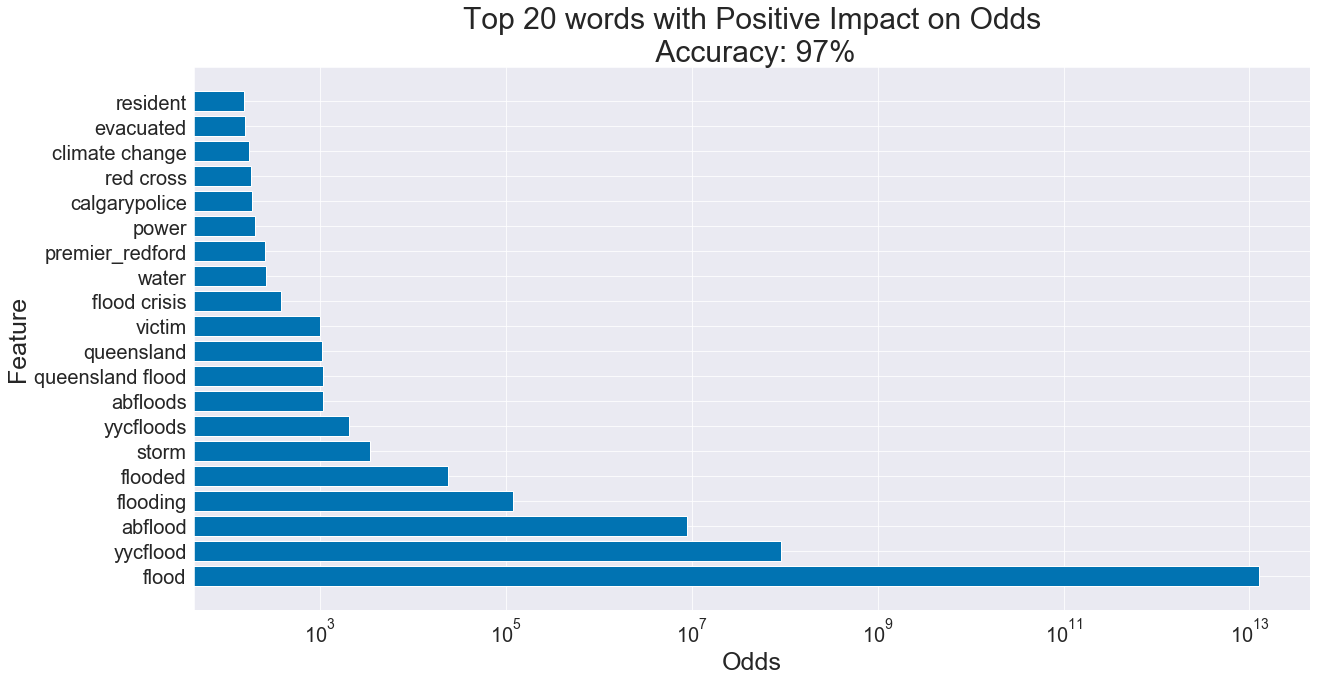

In [58]:
plt.figure(figsize=(20,10))
plt.barh(lr_fl_odds.sort_values(by='odds', ascending=False).head(20).index, 
         lr_fl_odds.sort_values(by='odds', ascending=False).head(20)['odds'],
         log=True)
plt.title('Top 20 words with Positive Impact on Odds\n Accuracy: 97%', fontsize=30)
plt.xlabel('Odds', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

- Similar to what was observed in the Sandy Hurricane data, the words with highest odds were either the disaster type or the name itself.

## All Disasters

Now, we'll model on the entire dataset to determine which words have the most information gained. The process will be the same as our prior two models.

### Model Prep

In [59]:
X = final_df[['lemmatized']]
y = final_df['label_on-topic']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    random_state=44)

#### TF-IDF

We instantiate TfidfVectorizer() and set the same parameters as before.

##### X_train

In [61]:
tfidf_all = TfidfVectorizer(ngram_range=(1, 2),
                            stop_words='english',
                            min_df=25, 
                            max_df=1.0)
X_train_tfidf = tfidf_all.fit_transform(X_train['lemmatized'])
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_all.get_feature_names())

##### Replicate for X_test

In [62]:
X_test_tfidf = tfidf_all.transform(X_test['lemmatized'])
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_all.get_feature_names())

In [63]:
X_test_tfidf_df.shape

(10016, 1874)

### Modeling

#### Baseline Model

In [64]:
y.value_counts(normalize=True)

True     0.538352
False    0.461648
Name: label_on-topic, dtype: float64

`on-topic` is our majority class again, with a similar imbalance as Alberta Floods and Queensland Flood. If we classify all tweets as being `on-topic`, we will be predicting correctly 53.84% of the time.

#### Random Forest

In [65]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [30, 35, 45],
    'min_samples_split': [2, 3, 5, 7, 10],
    'max_depth': [None, 5, 7, 10]
    
}
gs_rf_all = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf_all.fit(X_train_tfidf_df, y_train)
print('Score on Training Set:', gs_rf_all.score(X_train_tfidf_df, y_train))
print('Score on Testing Set:', gs_rf_all.score(X_test_tfidf_df, y_test))
gs_rf_all.best_params_

Score on Training Set: 0.9836256531434087
Score on Testing Set: 0.9451876996805112


{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 45}

-  For `y_train`, we will correctly predict the class in which a tweet belongs in `98.83%` of the time.
-  For `y_test`, we will correctly predict the class in which a tweet belongs in `94.42%` of the time.

### Confusion Matrix

In [66]:
cm = confusion_matrix(y_test, gs_rf_all.predict(X_test_tfidf_df))

In [67]:
cm_df = pd.DataFrame(cm, columns = ('predict_0','predict_1') , index = ('actual_0', 'actual_1'))
cm_df

,predict_0,predict_1
actual_0,4272,352
actual_1,197,5195


##### Important Features

We generated using gridsearch the most importance features that provide the most amount of information gained and plotted the top 20 words.

In [68]:
feat_importance = pd.DataFrame(gs_rf_all.best_estimator_.feature_importances_, X_train_tfidf_df.columns, columns=['importance'])

In [69]:
top_feat = feat_importance.sort_values('importance', ascending=False).head(20)

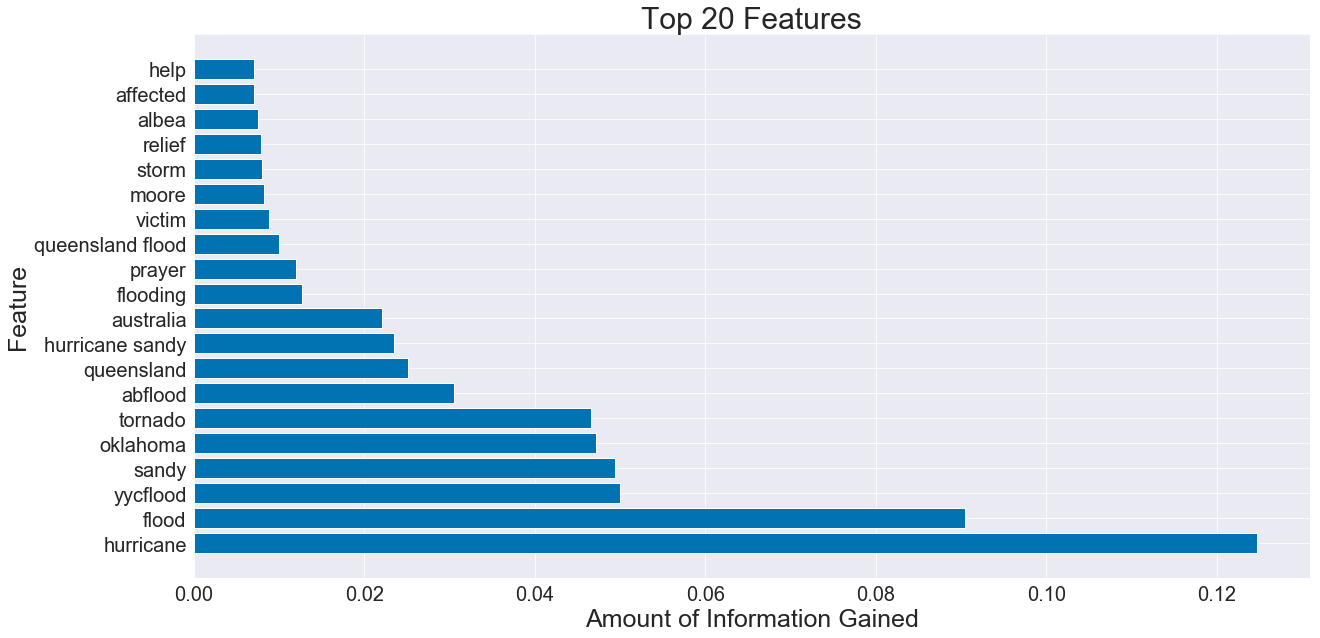

In [70]:
plt.figure(figsize=(20,10))
plt.barh(top_feat.index, top_feat['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of Information Gained', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  As expected, we see a lot of overlap between the top features here and our prior two models. 
-  Given that we're looking across three different disaster types, the information gained for terms relating to the disaster name and type is less than before.
-  For any disaster, the strongest indicator of whether a tweet is on-topic or off-topic will be the disaster type and name.

#### Logistic Regression

We will use logistic regression to measure feature importance and determine the words contained in tweets that give them high odds of being classified as `on-topic`. Grid-search was applied on logistic regression to calculate the best hyperparameters for our model.

In [71]:
lr = LogisticRegression()
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'penalty' : ['l1','l2']   
}
gs_lr_all = GridSearchCV(lr, param_grid = lr_params, scoring = 'roc_auc', cv = 3)
gs_lr_all.fit(X_train_tfidf_df, y_train)
print('Score on Training Set:', gs_lr_all.score(X_train_tfidf_df, y_train))
print('Score on Testing Set:', gs_lr_all.score(X_test_tfidf_df, y_test))
gs_lr_all.best_params_

Score on Training Set: 0.9833853599875809
Score on Testing Set: 0.9803131104455658


{'C': 1, 'penalty': 'l2'}

-  For `y_train`, we will correctly predict the class in which a tweet belongs in `98.34%` of the time.
-  For `y_test`, we will correctly predict the class in which a tweet belongs in `98.03%` of the time.

### Confusion Matrix

In [72]:
cm = confusion_matrix(y_test, gs_lr_all.predict(X_test_tfidf_df))

In [73]:
cm_df = pd.DataFrame(cm, columns = ('predict_0','predict_1') , index = ('actual_0', 'actual_1'))
cm_df

,predict_0,predict_1
actual_0,4367,257
actual_1,333,5059


##### Takeaways
- The model is still slightly overfitting to the train data because the variance explained from train data is 0.3% higher than the variance explained in the test data.

##### Odds

We made a table of the top 20 words with positive impact on odds meaning tweets with these words have the highest odds of being classified as `on-topic`. The tweets containing the word `flood` are 3.23 x 10^7 times as likely to be classified as `on-topic`.

In [74]:
lr_all_odds = pd.DataFrame(gs_lr_all.best_estimator_.coef_, columns = X_train_tfidf_df.columns).T
lr_all_odds.columns = ['weights']
lr_all_odds['odds'] = np.exp(lr_all_odds['weights'])
lr_all_odds.sort_values(by='odds', ascending=False).head(20)

,weights,odds
flood,17.290440,3.229554e+07
hurricane,16.912719,2.213607e+07
yycflood,12.013164,1.649114e+05
abflood,10.589337,3.970917e+04
tornado,10.304200,2.985776e+04
sandy,9.859402,1.913745e+04
oklahoma,7.998711,2.977119e+03
flooding,7.911237,2.727762e+03
frankenstorm,6.241974,5.138717e+02
storm,6.116661,4.533484e+02


We created a horizontal bar chart of the top 20 words of our logistic regression model that have the highest odds of classifying a tweet as `on-topic`.

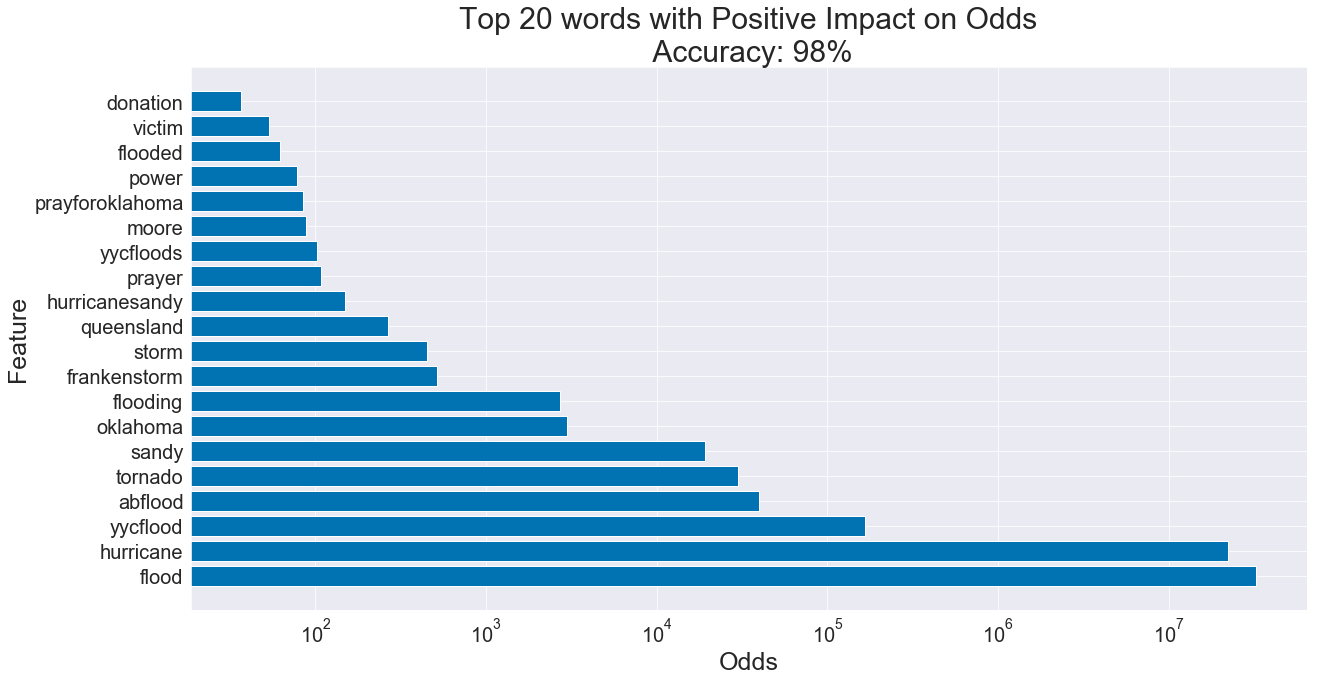

In [75]:
plt.figure(figsize=(20,10))
plt.barh(lr_all_odds.sort_values(by='odds', ascending=False).head(20).index, 
         lr_all_odds.sort_values(by='odds', ascending=False).head(20)['odds'],
         log=True)
plt.title('Top 20 words with Positive Impact on Odds\n Accuracy: 98%', fontsize=30)
plt.xlabel('Odds', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  As expected, we see a lot of overlap between the top features here and our prior two models. 
-  Given that we're looking across three different disaster types, the odds for terms relating to the disaster name and type is less than before.
-  For any disaster, the strongest indicator of whether a tweet is on-topic or off-topic will be the disaster type and name.

## Pickle Models for Future Predictions

In [76]:
with open('../assets/tfidf_flood.pkl', 'wb+') as f:
    pickle.dump(tfidf_fl, f)

In [77]:
with open('../assets/tfidf_flood_col.pkl', 'wb+') as f:
    pickle.dump(tfidf_fl.get_feature_names(), f)

In [78]:
with open('../assets/tfidf_all.pkl', 'wb+') as f:
    pickle.dump(tfidf_all, f)

In [79]:
with open('../assets/tfidf_all_col.pkl', 'wb+') as f:
    pickle.dump(tfidf_all.get_feature_names(), f)

In [80]:
with open('../assets/tfidf_hurricane.pkl', 'wb+') as f:
    pickle.dump(tfidf_sh, f)

In [81]:
with open('../assets/tfidf_hurricane_col.pkl', 'wb+') as f:
    pickle.dump(tfidf_sh.get_feature_names(), f)

In [82]:
with open('../assets/tfidf_tornado.pkl', 'wb+') as f:
    pickle.dump(tfidf_ot, f)

In [83]:
with open('../assets/tfidf_tornado_col.pkl', 'wb+') as f:
    pickle.dump(tfidf_ot.get_feature_names(), f)

In [84]:
with open('../assets/rf_flood.pkl', 'wb+') as f:
    pickle.dump(gs_rf_fl, f)

In [85]:
with open('../assets/rf_all.pkl', 'wb+') as f:
    pickle.dump(gs_rf_all, f)

In [86]:
with open('../assets/rf_hurricane.pkl', 'wb+') as f:
    pickle.dump(gs_rf_sh, f)

In [87]:
with open('../assets/rf_tornado.pkl', 'wb+') as f:
    pickle.dump(gs_rf_ot, f)

In [88]:
with open('../assets/lr_hurricane.pkl', 'wb+') as f:
    pickle.dump(gs_lr_sh, f)

In [89]:
with open('../assets/lr_flood.pkl', 'wb+') as f:
    pickle.dump(gs_lr_fl, f)

In [90]:
with open('../assets/lr_all.pkl', 'wb+') as f:
    pickle.dump(gs_lr_all, f)

In [91]:
with open('../assets/lr_tornado.pkl', 'wb+') as f:
    pickle.dump(gs_lr_ot, f)